# Лабораторная работа №5
# Линейные модели, SVM и деревья решений

### Цель лабораторной работы
Изучение линейных моделей, SVM и деревьев решений.

### Задание
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите следующие модели:
    - одну из линейных моделей;
    - SVM;
    - дерево решений.
5. Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.

### Дополнительные задания
- Проведите эксперименты с важностью признаков в дереве решений.
- Визуализируйте дерево решений.

# Ход выполнения лабораторной работы

In [205]:
import pandas as pd
import seaborn as sns
import numpy as np
from typing import Tuple, Dict
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree 
%matplotlib inline 
sns.set(style="ticks")

In [206]:
col_list = ['Pelvic_incidence',
               'Pelvic_tilt',
               'Lumbar_lordosis_angle',
               'Sacral_slope',
               'Pelvic_radius',
               'Degree_spondylolisthesis',
               'Pelvic_slope',
               'Direct_tilt',
               'Thoracic_slope',
               'Cervical_tilt',
               'Sacrum_angle',
               'Scoliosis_slope',
               'Class_att',
               'To_drop']
data = pd.read_csv('data/Dataset_spine.csv', names=col_list, header=1, sep=",")
data.drop('To_drop', axis=1, inplace=True)

In [207]:
data.head()

,Pelvic_incidence,Pelvic_tilt,Lumbar_lordosis_angle,Sacral_slope,Pelvic_radius,Degree_spondylolisthesis,Pelvic_slope,Direct_tilt,Thoracic_slope,Cervical_tilt,Sacrum_angle,Scoliosis_slope,Class_att
0,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
1,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
2,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
3,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal
4,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,0.789993,29.3230,12.0036,10.40462,-1.512209,9.6548,Abnormal


In [208]:
data.isnull().sum()

Pelvic_incidence            0
Pelvic_tilt                 0
Lumbar_lordosis_angle       0
Sacral_slope                0
Pelvic_radius               0
Degree_spondylolisthesis    0
Pelvic_slope                0
Direct_tilt                 0
Thoracic_slope              0
Cervical_tilt               0
Sacrum_angle                0
Scoliosis_slope             0
Class_att                   0
dtype: int64

Пропуски данных отсутствуют.

In [209]:
data['Class_att'] = data['Class_att'].map({'Abnormal': 1, 'Normal': 0})

Разделим выборку на обучающую и тестовую:

In [210]:
# Разделим данные на целевой столбец и признаки
X = data.drop("Class_att", axis=1)
Y = data["Class_att"]

In [211]:
# С использованием метода train_test_split разделим выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((231, 12), (78, 12), (231,), (78,))

### Линейная модель

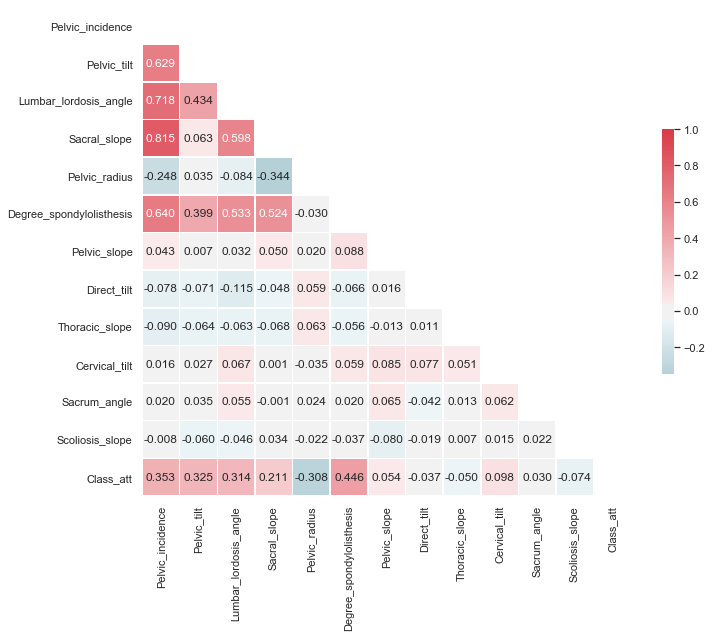

In [212]:
#Построим корреляционную матрицу
sns.set(style="white")
corr = data.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
g=sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, fmt='.3f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

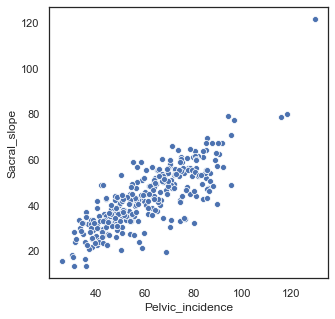

In [213]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x='Pelvic_incidence', y='Sacral_slope', data=data)

In [214]:
x_array = data['Pelvic_incidence'].values
y_array = data['Sacral_slope'].values

In [215]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-x_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [216]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(4.565546113493063, 0.6347707526286969)

In [217]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [218]:
y_array_regr = y_regr(x_array, b0, b1)

In [219]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        # используется векторизованное умножение и сложение для вектора и константы
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        # np.multiply - поэлементное умножение векторов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred

In [220]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = 4.565546113493063 - (теоретический), 1 - (градиентный спуск)
b1 = 0.6347707526286969 - (теоретический), 1 - (градиентный спуск)
MSE = 382.8630387134672


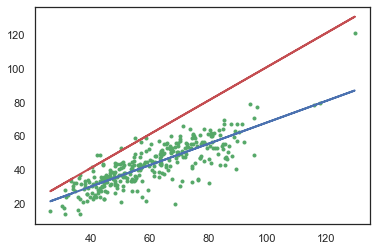

In [221]:
# Примеры использования градиентного спуска
show_gradient_descent(0, 1, 1)

b0 = 4.565546113493063 - (теоретический), 1 - (градиентный спуск)
b1 = 0.6347707526286969 - (теоретический), 0.7 - (градиентный спуск)
MSE = 1.4084724961222816


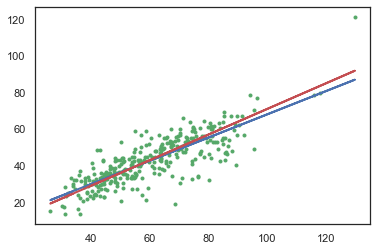

In [222]:
show_gradient_descent(0, 1, 0.7)

In [223]:
# Обучим линейную регрессию и сравним коэффициенты с рассчитанными ранее
reg1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))
(b1, reg1.coef_), (b0, reg1.intercept_)

((0.6347707526286969, array([[0.63477075]])),
 (4.565546113493063, array([4.56554611])))

### SVM

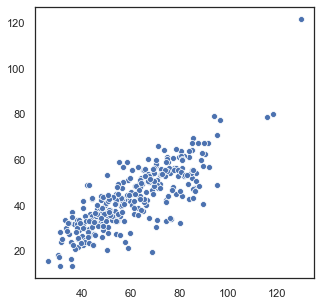

In [224]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x=x_array, y=y_array)

In [225]:
def plot_regr(clf):
    title = clf.__repr__
    clf.fit(x_array.reshape(-1, 1), y_array)
    y_pred = clf.predict(x_array.reshape(-1, 1))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(x_array, y_array, 'b.')
    ax.plot(x_array, y_pred, 'ro')
    plt.show()

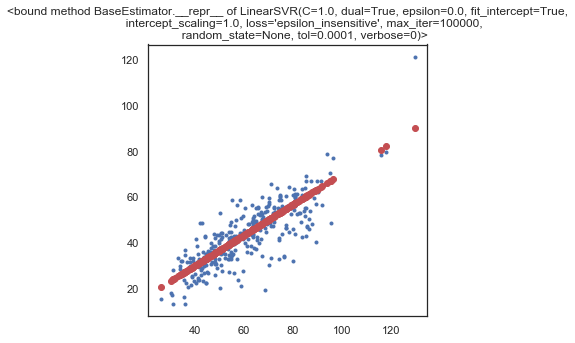

In [226]:
plot_regr(LinearSVR(C=1.0, max_iter=100000))

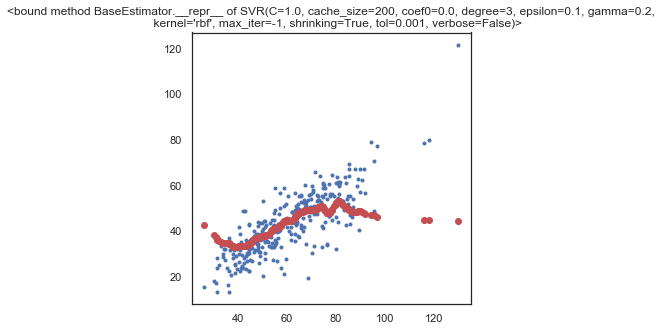

In [227]:
plot_regr(SVR(kernel='rbf', gamma=0.2, C=1.0))

### Дерево решений

In [228]:
# Обучим дерево на всех признаках
tree = DecisionTreeRegressor(random_state=1)
tree.fit(X_train, Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')

In [229]:
# Важность признаков
list(zip(X_train.columns.values, tree.feature_importances_))

[('Pelvic_incidence', 0.03881985535831688),
 ('Pelvic_tilt', 0.0648640652612829),
 ('Lumbar_lordosis_angle', 0.06149200087661627),
 ('Sacral_slope', 0.08263904265020883),
 ('Pelvic_radius', 0.181238439623055),
 ('Degree_spondylolisthesis', 0.41411903317709764),
 ('Pelvic_slope', 0.023065828402366866),
 ('Direct_tilt', 0.01842735042735041),
 ('Thoracic_slope', 0.07000532439464523),
 ('Cervical_tilt', 0.007145299145299295),
 ('Sacrum_angle', 0.038183760683760684),
 ('Scoliosis_slope', 0.0)]

In [230]:
# Важность признаков в сумме дает единицу
sum(tree.feature_importances_)

1.0

In [231]:
def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

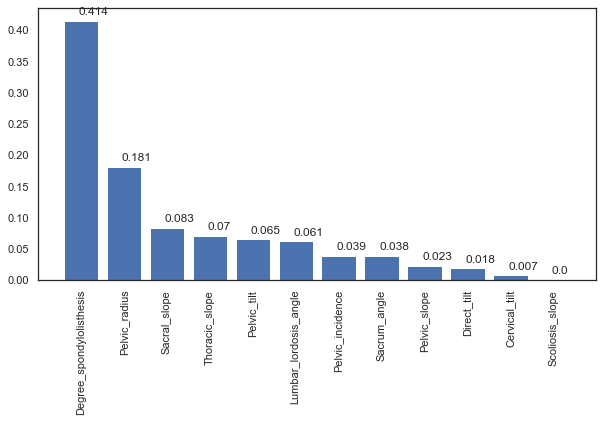

In [232]:
tree_fl, tree_fd = draw_feature_importances(tree, X_train)

In [233]:
# Список признаков, отсортированный на основе важности, и значения важности
tree_fl, tree_fd

(['Degree_spondylolisthesis',
  'Pelvic_radius',
  'Sacral_slope',
  'Thoracic_slope',
  'Pelvic_tilt',
  'Lumbar_lordosis_angle',
  'Pelvic_incidence',
  'Sacrum_angle',
  'Pelvic_slope',
  'Direct_tilt',
  'Cervical_tilt',
  'Scoliosis_slope'],
 [0.41411903317709764,
  0.181238439623055,
  0.08263904265020883,
  0.07000532439464523,
  0.0648640652612829,
  0.06149200087661627,
  0.03881985535831688,
  0.038183760683760684,
  0.023065828402366866,
  0.01842735042735041,
  0.007145299145299295,
  0.0])

In [234]:
X_train.head()

,Pelvic_incidence,Pelvic_tilt,Lumbar_lordosis_angle,Sacral_slope,Pelvic_radius,Degree_spondylolisthesis,Pelvic_slope,Direct_tilt,Thoracic_slope,Cervical_tilt,Sacrum_angle,Scoliosis_slope
291,34.756738,2.631740,29.504381,32.124998,127.139850,-0.460894,0.281612,24.1257,11.2762,11.54866,-12.025220,44.3412
17,38.697912,13.444749,31.000000,25.253163,123.159251,1.429186,0.306581,28.3015,17.9575,14.75417,-14.252676,24.9361
110,84.998956,29.610098,83.352194,55.388858,126.912990,71.321175,0.998827,7.0551,9.0119,9.85541,-19.314135,43.0086
228,43.436451,10.095743,36.032224,33.340707,137.439694,-3.114451,0.283589,36.0097,11.0132,8.51675,-23.904190,35.0749
125,70.676898,21.704402,59.181161,48.972496,103.008355,27.810148,0.039655,15.7748,14.8568,11.45991,-18.475476,19.8407


In [235]:
# Пересортируем признаки на основе важности
X_train_sorted = X_train[tree_fl]
X_train_sorted.head()

,Degree_spondylolisthesis,Pelvic_radius,Sacral_slope,Thoracic_slope,Pelvic_tilt,Lumbar_lordosis_angle,Pelvic_incidence,Sacrum_angle,Pelvic_slope,Direct_tilt,Cervical_tilt,Scoliosis_slope
291,-0.460894,127.139850,32.124998,11.2762,2.631740,29.504381,34.756738,-12.025220,0.281612,24.1257,11.54866,44.3412
17,1.429186,123.159251,25.253163,17.9575,13.444749,31.000000,38.697912,-14.252676,0.306581,28.3015,14.75417,24.9361
110,71.321175,126.912990,55.388858,9.0119,29.610098,83.352194,84.998956,-19.314135,0.998827,7.0551,9.85541,43.0086
228,-3.114451,137.439694,33.340707,11.0132,10.095743,36.032224,43.436451,-23.904190,0.283589,36.0097,8.51675,35.0749
125,27.810148,103.008355,48.972496,14.8568,21.704402,59.181161,70.676898,-18.475476,0.039655,15.7748,11.45991,19.8407


In [236]:
Y_test_predict = tree.predict(X_test)

In [237]:
mean_absolute_error(Y_test, Y_test_predict)

0.11538461538461539

In [238]:
# Обучим дерево и предскажем результаты на пяти лучших признаках 
tree_2 = DecisionTreeRegressor(random_state=1).fit(X_train[tree_fl[0:5]], Y_train)
Y_test_predict_2 = tree_2.predict(X_test[tree_fl[0:5]])

In [239]:
mean_absolute_error(Y_test, Y_test_predict_2)

0.16666666666666666

In [240]:
# Исследуем, как изменяется ошибка при добавлении признаков в порядке значимости
X_range = list(range(1, len(X_train.columns)+1))
X_range

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [241]:
mae_list = []
for i in X_range:
    # Обучим дерево и предскажем результаты на заданном количестве признаков 
    tree_3 = DecisionTreeRegressor(random_state=1).fit(X_train[tree_fl[0:i]], Y_train)
    Y_test_predict_3 = tree_3.predict(X_test[tree_fl[0:i]])
    temp_mae = mean_absolute_error(Y_test, Y_test_predict_3)
    mae_list.append(temp_mae)

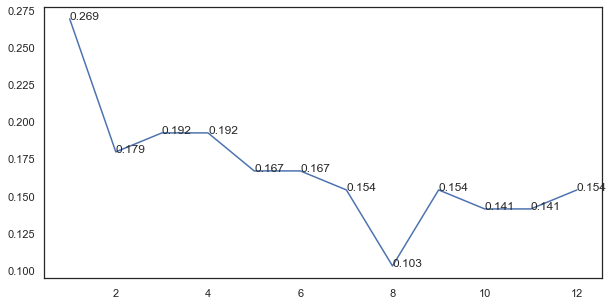

In [242]:
plt.subplots(figsize=(10,5))
plt.plot(X_range, mae_list)
for a,b in zip(X_range, mae_list):
    plt.text(a, b, str(round(b,3)))
plt.show()

### Оценка качества моделей

Дерево решений

In [243]:
print("r2_score:", r2_score(Y_test, tree.predict(X_test)))
print("mean_squared_error:", mean_squared_error(Y_test, tree.predict(X_test)))

r2_score: 0.4701886792452832
mean_squared_error: 0.11538461538461539


Линейная регрессия

In [244]:
pred = reg1.predict(x_array.reshape(-1, 1))
print("r2_score:", r2_score(y_array, pred))
print("mean_squared_error", mean_squared_error(y_array, pred))

r2_score: 0.664423352506976
mean_squared_error 60.45739674813066


Метод опорных векторов

In [245]:
svr = SVR(kernel='rbf')
svr.fit(X_train, Y_train)
print("r2_score:", r2_score(Y_test, svr.predict(X_test)))
print("mean_squared_error", mean_squared_error(Y_test, svr.predict(X_test)))

r2_score: 0.5993410854165501
mean_squared_error 0.08725724224573822


Последние две модели являются приемлемыми, т.к. коэффициент детерминации для всех трех моделей больше 50%. 

Если учитывать показатели обеих метрик, наилучший результат показал метод опорных векторов.